# Kaggle Titanic competition : Version2

I am going to improve my previous scores on the Titanic competition with features engineering. The goal is to lose less data and to improve the prediction with different classifiers.

## Loading the data

In [20]:
# Imports specific libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style='ticks', palette='deep')

In [48]:
# Load train and test data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [49]:
# Info on train data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


The maximum observation we can get is **891**. Some features seems to have Null values like: 
+ Age
+ Cabin
+ Embarked

We'll keep in mind these features and check for the test data.

In [50]:
# Info on test data
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


We have **418** entries available. The features with missing values are:
+ Age
+ Fare
+ Cabin

With the train data, we have a total of **1309 observation**. As the test has missing values, we should preprocess it with the train data. We are going to regroup train and test together to preprocess

In [51]:
# Keep ID of test passengers
test_ID = test.loc[:,'PassengerId']
test_ID.count()

418

In [52]:
# Regroup train and test data together
# We get rid of survived since it is our target
raw_data = pd.concat([train.drop(['Survived'], axis=1), test]).reset_index(drop=True)
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Pclass       1309 non-null   int64  
 2   Name         1309 non-null   object 
 3   Sex          1309 non-null   object 
 4   Age          1046 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1308 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1307 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 112.6+ KB


### Outliers removal

We have to remove outliers from the train data before analysing each features. Our future observations could be under the influence of outliers. I have checked [Statology](https://www.statology.org/remove-outliers-python/) and I have decided to go for the **Z-score** to detect the outliers. We should do it for numerical data.

In [136]:
def outliers_z_score(df,features):
    """
    Compute Z-score from a dataframe with specific features and return an set of row indices of outliers.
    """
    ot_indexes = []
    for feature in features:
        # Get feature serie
        feature_serie = df[feature]
        
        # Compute mean and standard deviation
        mean = feature_serie.mean()
        std = feature_serie.std()
        
        # Compute Z-score for each values
        z_serie = feature_serie.apply(lambda x: abs((x-mean)/std))
        
        # Store outliers indexes
        indexes = df[z_serie > 3].index.values
        ot_indexes.extend(indexes)
    
    return set(ot_indexes) 
        

In [137]:
train.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

In [140]:
# Z-score computation to detect outliers
cols = ['Age', 'SibSp', 'Parch', 'Fare']
ot_indexes = outliers_z_score(train, cols)

In [141]:
# Number of outliers
len(ot_indexes)

66

In [143]:
# Remove outliers from the train data
train_ot = train.drop(ot_indexes, axis=0)

In [145]:
# Compare shape of train with/without outliers
print('Shape train with ot:', train.shape)
print('Shape train without ot:', train_ot.shape)

Shape train with ot: (891, 12)
Shape train without ot: (825, 12)


In [147]:
# Describe raw train data
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.00,891.00,891.00,714.00,891.00,891.00,891.00
mean,446.00,0.38,2.31,29.70,0.52,0.38,32.20
std,257.35,0.49,0.84,14.53,1.10,0.81,49.69
min,1.00,0.00,1.00,0.42,0.00,0.00,0.00
25%,223.50,0.00,2.00,20.12,0.00,0.00,7.91
50%,446.00,0.00,3.00,28.00,0.00,0.00,14.45
75%,668.50,1.00,3.00,38.00,1.00,0.00,31.00
max,891.00,1.00,3.00,80.00,8.00,6.00,512.33


In [146]:
# Describe train without outliers
train_ot.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,825.00,825.00,825.00,657.00,825.00,825.00,825.00
mean,445.60,0.39,2.31,30.13,0.35,0.25,25.89
std,255.33,0.49,0.83,14.03,0.62,0.56,29.79
min,1.00,0.00,1.00,0.42,0.00,0.00,0.00
25%,226.00,0.00,2.00,21.00,0.00,0.00,7.90
50%,447.00,0.00,3.00,28.50,0.00,0.00,13.00
75%,662.00,1.00,3.00,38.00,1.00,0.00,27.72
max,891.00,1.00,3.00,71.00,3.00,2.00,164.87


By using the Z-score with a threshold of 3, we have removed 66 rows considered as outliers. Fare was one with the most outliers (mean : 32.20 to 25.89), as for SibSp or Parch.

## Context of data

**“What sorts of people were more likely to survive?”** This is the question. So before preprocessing our raw_data blindly, we need to understand the background of the Titanic incident. Name, age, gender, or socio-economic class could have influenced the survival of groups of people. Let's see if the distribution of survivors by their gender with the train data.

### Features relationship

We are going to check the relationship between each features in order to get a general idea. 

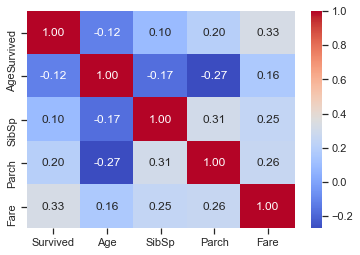

In [157]:
# Heatmap of correlation between numerical features
sns.heatmap(
    data=train_ot[['Survived', 'Age', 'SibSp', 'Parch', 'Fare']].corr(), 
    annot=True, fmt=".2f", 
    cmap = "coolwarm"
    )

### Gender - Survived distribution

Why gender? Because : "Women and children first!". But also instructions leaks some ways to handle the preprocessing.

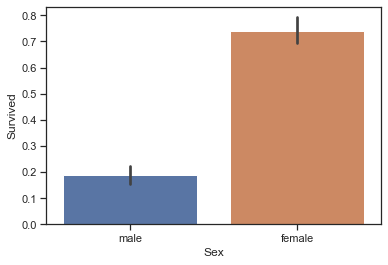

In [26]:
# Barplot Gender-Survived
sns.barplot(x="Sex", y="Survived", data=train_ot)

In [33]:
# Percentage of survivors by genders
pd.options.display.float_format = '{:,.2f}'.format # allows to display float in .2f
train_ot.groupby('Sex').agg({'Survived': 'mean'})

,Survived
Sex,
female,0.74
male,0.19


There are more women survivors than male. Gender seems to be a good indicator of survival, we should keep it for further investigation.

### Age - Survived distribution

Although we have missing values with age, we need to check the distribution

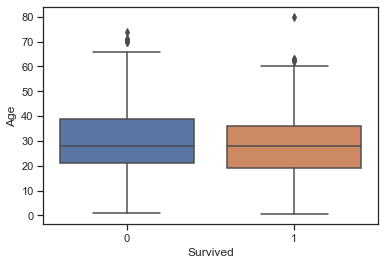

In [40]:
# Beeswarm Gender-Survived
sns.boxplot(x="Survived", y="Age", data=train_ot);

In [45]:
# EDA on Age of survivors
train_ot.groupby('Survived').agg({'Age': ('mean', 'median', np.std)})

Age             
          mean median   std
Survived                   
0        30.63  28.00 14.17
1        28.34  28.00 14.95